# ⭐AIFFEL 대전 1기 Exploration 10. 인물모드 사진 만들기⭐
>  프로젝트 소개: 이미지 세그멘테이션을 통해 인물모드 사진 만들기

***

# 🎯 프로젝트 목표
* 인물 사진, 고양이 사진을 이용해 인물 모두 사진을 만들어라.
* 새로운 배경사진으로 교체한 사진을 만들어라.
* 마스킹 결과 개선 방법에 대해 솔루션 제시하라.

***

# ✅프로젝트 순서
## 1. 인물 사진으로 세그멘테이션하기
## 2. DeepLab 모델 준비
## 3. 마스크를 만들고 시각화
## 4. 세그멘테이션 결과(mask)를 원래 크기로 복원
## 5. 배경 흐리게 하기 (1) - 배경 추출
## 6. 배경 흐리게 하기 (2) - 흐릿하게 만들기
## 7. 흐릿하게 바뀐 배경과 잘라낸 인물 사진 합치기
## 8. 고양이 사진으로 세그멘테이션 하기
## 9. 세그멘테이션을 이용해 새로운 배경 합성
## 10. 문제점 파악
- 10-1. 인물 사진과 흐릿한 배경  
- 10-2. 고양이 사진  
- 10-3. 새로운 배경 합성  

## 11. 해결 방법 제안
- 11-1. 3D Depth Camera 활용하기  
- 11-2. 깊이 영상(Depth image)활용하기  

## 12. 회고
- 12-1. 루브릭 평가  
- 12-2. 회고

***

# 0. 개념 정리
### 1) 셸로우 포커스(Shallow Focus): 피사체를 가깝게 촬영하면 배경이 흐려지는 초점법. 얕은 피사계 심도(shallow depth of field)이라도고 부른다.
![image](pics/baby.png)
> [인물사진 모드 예시 (출처: https://pixabay.com/ko/photos/아기-소녀-절전-모드-어린이-1151351/)]  

### 2) 세그멘테이션(Segmentation): 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
#### 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정.

### 3) 시멘틱 세그멘테이션(Semantic Segmentation): 세그멘테이션 중에서도 우리가 인식하는 세계와 같이 물리적인 의미 단위로 인식하는 세그멘테이션. (예시: 사람, 비행기, 자동차, 컵 등의 물리적 단위로 분류하는 방법)
![image_1](pics/seg_1.png)
> [MS COCO datasets의 시맨틱 세그멘테이션 라벨 (출처: http://cocodataset.org/#explore)]  

### 4) 인스턴스 세그멘테이션(Instance Segmentation): 사람 개개인별로 다른 라벨을 가지게 한다. 시멘틱 세그멘테이션은 '사람'이 누구인지 관계없이 같은 라벨로 표현하지만 인스턴스 세그멘테이션은 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하는것이 목표.  

### 5) 워터쉐드 세그멘테이션(Watershed segmentation): 이미지를 그레이 스케일로 변환하면 0~255의 값을 가지는데 픽셀값을 이용해 각 위치의 높고 낮음을 구분할 수 있다. 낮은 부분부터 서서히 물을 채워 나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘칠 때 경계를 생성하는 기법이다.

### 6) 세그멘테이션을 구현할 수 있는 모델
- FCN
- SegNet
- U-Net
- DeepLab

## 세그멘테이션 보강하기
### 7) 피사계 심도 이해하기
- 관련 링크: [피사계 심도](https://ggyul.tistory.com/12)  

### 8) 3D Depth Camera
- 카메라 2개를 통한 3d 이미지 얻기  
- 관련 링크: [3D Depth Camera](https://m.blog.naver.com/panoptics/221336152952)  

### 9) 깊이 영상 활용하기
- Struct2Depth(구글 brain 논문에서 소개) 기법 (카메라 1개여도 가능)
- 관련 링크1: [깊이 영상 1](https://sites.google.com/view/struct2depth)  
- 관련 링크2: [깊이 영상 2](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)  

### 10) IR(적외선)을 활용한 사례
- 구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능  
- 관련 링크: [IR(적외선)을 이용한 3d depth sensing](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

***

### 필요 라이브러리 불러오기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 1. 인물 사진으로 세그멘테이션하기

### 이미지 불러오기 - (1) 인물 사진

In [2]:
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/image2.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(750, 1000, 3)


### 원본 이미지 출력

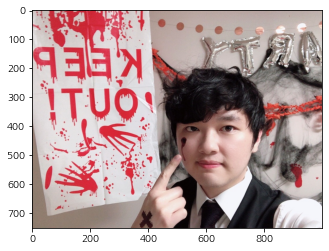

In [3]:
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 2. DeepLab 모델 준비

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 사전 학습 가중치 불러오기 (deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight)

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj40/aiffel/human_segmentation/models
model loaded successfully!


### 첫 단계에서 준비한 이미지를 네트워크에 입력  
- `img_orig`의 크기는 `750*1000`이고 `img_resized`의 크기는 `384*513`이 출력
- 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값): 15

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(750, 1000, 3) (384, 513, 3) 15


### 15의 의미?
- `person`. 사람을 의미한다

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print(LABEL_NAMES[15])

person


# 3. 마스크를 만들고 시각화
- 15를 가진 영역만 출력

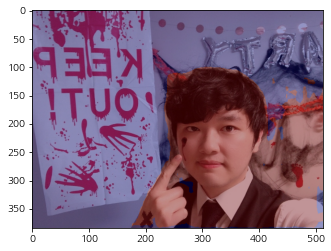

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 세그멘테이션 결과(mask)를 원래 크기로 복원
- DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했었다.
- 아래 두개의 그림의 크기를 확인(x축, y축의 scale이 다르다)

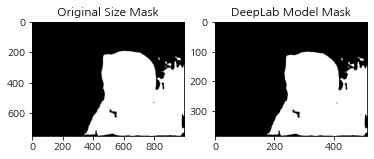

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 5. 배경 흐리게 하기 (1) - 배경 추출
- 세그멘테이션 마스크를 이용해서 배경만 추출

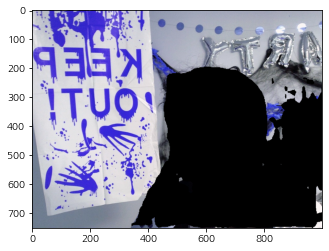

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

# 6. 배경 흐리게 하기 (2) - 흐릿하게 만들기
- `blur`를 이용해 배경을 흐리게 처리

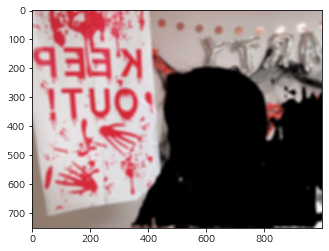

In [11]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 7. 흐릿하게 바뀐 배경과 잘라낸 인물 사진 합치기
- numpy.where() 이용
> 참고: [numpy.where() 사용법](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

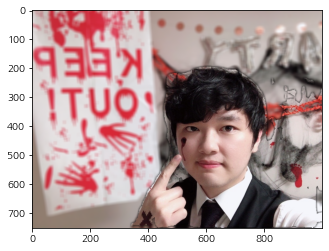

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

***

# 8. 고양이 사진으로 세그멘테이션 하기

### 이미지 불러오기 - (2) 고양이 사진

In [13]:
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/cat_1.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1280, 1920, 3)


### 원본 이미지 출력

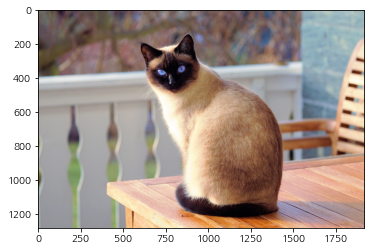

In [14]:
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 이미지를 네트워크에 입력 

In [15]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 1920, 3) (342, 513, 3) 11


### 11의 의미?
- `diningtable`. **테이블...을 의미...❓❓**  

#### 다른 고양이 사진으로 해보자

In [16]:
print(LABEL_NAMES[seg_map.max()]) # 저녁식사 테이블...??

diningtable


***

### 고양이 사진 변경
- 변경 후에는 잘 인식된다!

In [17]:
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/cat_2.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1299, 1920, 3)


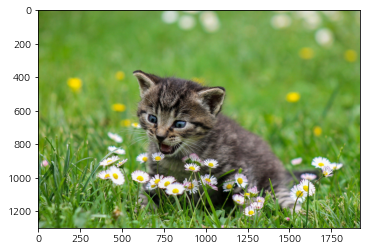

In [18]:
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [19]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1299, 1920, 3) (347, 513, 3) 8


In [20]:
print(LABEL_NAMES[seg_map.max()]) # 고양이다!!

cat


### 마스크를 만들고 시각화
- 8를 가진 영역만 출력  

**>> 고양이만 붉은 색으로 잘 인식한 것을 확인!**

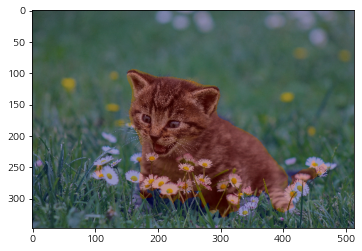

In [21]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과(mask)를 원래 크기로 복원
- DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했었다.
- 아래 두개의 그림의 크기를 확인(x축, y축의 scale이 다르다)

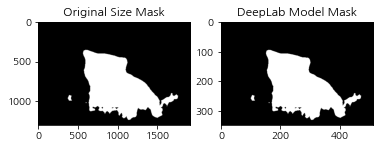

In [22]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 흐리게 하기 (1) - 배경 추출
- 세그멘테이션 마스크를 이용해서 배경만 추출

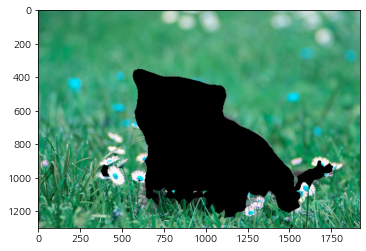

In [23]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

### 배경 흐리게 하기 (2) - 흐릿하게 만들기
- `blur`를 이용해 배경을 흐리게 처리

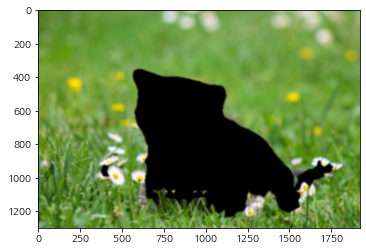

In [24]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐릿하게 바뀐 배경과 잘라낸 인물 사진 합치기
- numpy.where() 이용

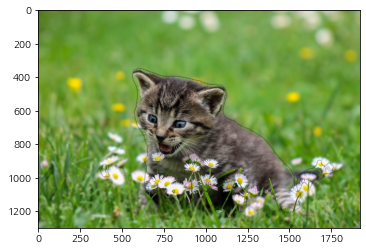

In [25]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

***

# 9. 세그멘테이션을 이용해 새로운 배경 합성

### 이미지 불러오기 - (3) 배경 교체하기

In [26]:
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/pic3.JPG'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1000, 750, 3)


### 인물 이미지 출력

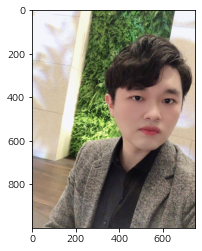

In [27]:
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [28]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1000, 750, 3) (513, 384, 3) 15


### 변경할 배경 사진 불러오기
- 여행 가고 싶은 마음을 담아...그리고 AIFFEL의 어원이기도 한 에펠탑 소환!

In [29]:
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/eiffel.jpg'
img_bg_blur = cv2.imread(img_path) 
print (img_bg_blur.shape)

(1279, 1920, 3)


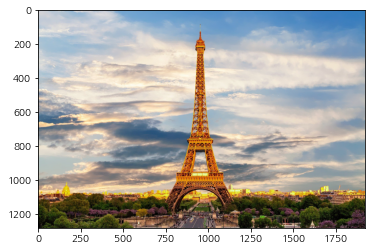

In [30]:
img_rgb = cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 마스크를 만들고 시각화
- 15를 가진 영역만 출력  

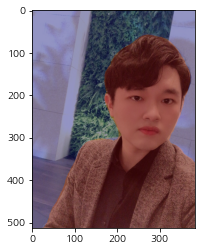

In [31]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과(mask)를 원래 크기로 복원
- DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했었다.
- 아래 두개의 그림의 크기를 확인(x축, y축의 scale이 다르다)

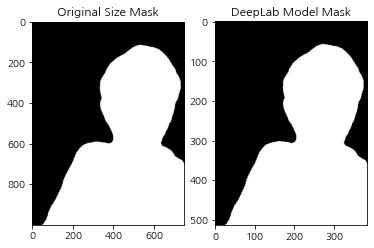

In [32]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

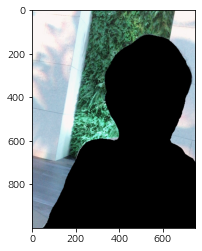

In [33]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

### 인물 사진과 새로운 배경 사진 합치기
- 에펠탑이 잘 안 보인다...

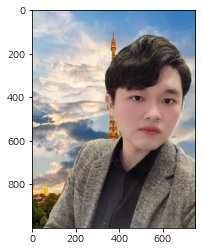

In [34]:
img_bg_blur = cv2.resize(img_bg_blur, (750, 1000))
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### ❗새로운 시도❗
**numpy.where를 이용하면 새로운 배경 사이즈 조정없이 인물 사진은 작게 표현해 합성할 수 있지 않을까?**  
**아래는 그런 생각에서 시도한 결과가 있다.**

***

### 새로운 배경 사진 크기 그대로 + 인물 이미지만 잘라서 합성
- 위에서는 에펠탑이 잘 보이지 않는다!
- 인물과 에펠탑이 잘 나오게 해보자~~

In [35]:
# 배경 사진 불러오기
import os
img_path = os.getenv('HOME')+'/1.AIFFEL_Study/Exploration/E10_Image_Semantic_Segmentation/pics/eiffel.jpg'
img_new_bg = cv2.imread(img_path) 
print (img_new_bg.shape) # (세로, 가로, 채널수)

(1279, 1920, 3)


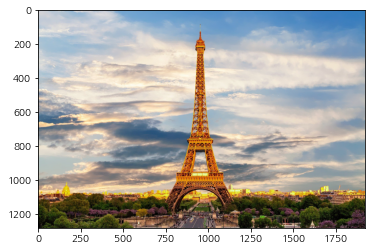

In [36]:
# 배경 사진 확인
img_rgb = cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 인물 사진 중 잘라낸 영역 확인 (mask)
- 흰색 영역 == 인물 사진으로 대체
- 검은 영역 == 배경 사진 그대로 사용

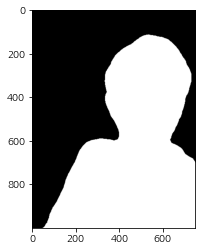

In [37]:
# 검은건 배경이요
# 하얀건 사람이다

img_mask_color_ = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_mask_color_rgb = cv2.cvtColor(img_mask_color_, cv2.COLOR_BGR2RGB)
plt.imshow(img_mask_color_rgb)
plt.show()

### 인물 사진이 들어갈 위치 조정
- 우측 하단에 위치하도록 좌표값 설정

In [38]:
# 인물 사진 위치 중 좌측 상단 = (1279-1000, 1920-750)
# 인물 사진 위치 중 우측 하단 = (1279, 1920) # 세로, 가로

person_left_top_x = img_new_bg.shape[1] - img_orig.shape[1]
person_left_top_y = img_new_bg.shape[0] - img_orig.shape[0]
person_right_down_x = img_new_bg.shape[1]
person_right_down_y = img_new_bg.shape[0]

print('배경 사진 중 인물 사진이 들어갈 위치 중 좌측 상단 좌표값은 ({},{})이며 우측 하단 좌표값은 ({},{})이다.'\
      .format(person_left_top_x,person_left_top_y,person_right_down_x,person_right_down_y))

배경 사진 중 인물 사진이 들어갈 위치 중 좌측 상단 좌표값은 (1170,279)이며 우측 하단 좌표값은 (1920,1279)이다.


### 인물 사진만 잘라내서 새로운 배경에 합성
- E03에서 했던 내용을 차용해 실행
- numpy.where를 이용해 mask영역이 흰색이면 img_orig(인물사진), 아니라면 person_area(원래 배경)으로 표현

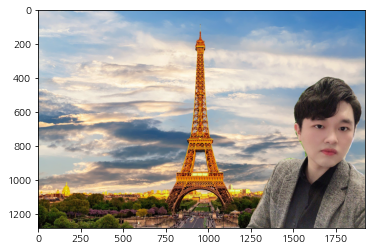

In [39]:
person_area = img_new_bg[person_left_top_y:person_right_down_y, person_left_top_x:person_right_down_x]

img_new_bg[person_left_top_y : person_right_down_y, person_left_top_x : person_right_down_x] = \
np.where(img_mask_color_==255, img_orig, person_area)
plt.imshow(cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB))
plt.show()

**🗼WOW! 에펠탑을 배경으로 잘 찍은 것 같다!!🗼**

***

# 10. 문제점 파악

## 10-1. 인물 사진과 흐릿한 배경
### >> 사진 우측까지도 인물로 인식해버리는 문제 발생
![image](pics/E10_Problem_1_.png)

## 10-2. 고양이 사진
### >> 경계선이 보이는 문제
![image](pics/E10_Problem_2.png)

## 10-3. 새로운 배경 합성
### >> 원래 배경이 조금 남아 있는 현상
![image](pics/E10_Problem_3.png)

***

# 11. 해결 방법 제안
- 세그멘테이션의 한계: 피사계심도를 이용한 스웰링 효과는 심도를 표현하지만 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘들다.  

## 11-1. 3D Depth Camera 활용하기
- 카메라 1대로 촬영한 이미지로 semantic segmentation을 하게 되면 심도가 정확하게 표현되지 않는다.  
- 하지만 카메라 2대를 이용해 픽셀의 깊이를 측정해 사물을 입체적으로 표현할 수 있고 높이 또는 깊이를 측정할 수 있다.  

#### 하지만 우리는 카메라 1대로 촬영한 이미지에 대해 개선할 수 있는 해결방법이 필요함.

## 11-2. 깊이 영상(Depth image) 활용하기
- Google Brain논문에서 소개한 Struct2Depth 기법 이용  

#### 두 개의 링크의 글을 보고 파악한 것은 영상에서 사용하는 기법으로 이해했다.
#### frame 0이 있다면 frame -1, frame 1을 이용해 `Depth Network`와 `Pose Network`를 이용해 `Appearance loss` 즉, 가려진 부분을 예측하는 내용을 보여줬다. 
#### 전체 학습은 아래와 같다. 여기서 `(a)`의 `Depth Network`를 이용하면 어떨까?
![Struct2Depth_Training](paper/paper_3.png)  


#### 그리고 글에서 말한 `U-Net`을 이용한다면 `Depth Network`를 만들 수 있겠다는 생각이 들었다. 간단한 구조는 아래와 같다.
![simple of U-Net](paper/paper_1.png)

### 그런데 논문에서 제안한 것은 크게 두 가지가 있는데 `Monodepth2`와 개선된 `Monodepth2Extension: Struct2Depth`이었다!

## 그럼 LMS저자가 추천한 `Struct2Depth`에 대해 알아보자.
- 기본적으로 위에서는 `Depth Network`와 `Pose Network`를 사용했다. 여기선 `Pose Network`대신 `ego-motion Network`를 사용한다.
- 크게 어떤 순서로 진행되는지는 아래와 같다. 

1. 잠재적으로 움직이는 물체의 분할을 포착하기 위해 사전 훈련된 마스크 R-CNN이 적용된다.  
2. 2진수 마스크는 정적 영상(프레임 -1, 프레임 0 및 프레임 +1)에서 잠재적으로 움직이는 객체를 제거하는 데 사용됩니다.  
3. 마스크된 영상이 ego-motion 네트워크로 전송되고 프레임 -1과 0, 프레임 0과 +1 사이의 변환 매트릭스가 출력됩니다.  

![Sample output for Mask R-CNN [2]. Image from [2].](paper/paper_9.png)
> Sample output for Mask R-CNN.  

여기서 1번에서 **사전 훈련된 마스크 R-CNN**을 적용하는데 위 그림은 샘플 이미지이다.  
우리는 영상이 아니기 때문에 2번 이후의 단계는 적용할 수 없을 것이라 판단된다.  
그렇다면 **`Depth Network`와 `사전 훈련된 R-CNN`을 이용하면 이미지 마스킹을 더 잘할 수 있지 않을까❓**하는 생각이 들었다❗  

중간에 어려운 수식도 나오고 이미지에 한정적으로 적용을 어떻게 해야하나 어려운데 아래 그림을 보면서 생각해보자.  
여기서는 입력 시퀀스가 있으면 `ego-motion network`와 `Depth net` 그리고 `Object motion network`와 `Depth net`에 의해 정리된(Wraped) `egomotion`과 `object`가 나와 결과를 출력하고 있다.  
![구조체 2 깊이에서 가져온 이미지입니다. 가운데 열은 카메라의 동일한 속도로 움직이는 물체에 무한 깊이가 할당되는 문제를 보여 줍니다. 세 번째 열에는 이를 개선하는 방법이 나와 있습니다.](paper/paper_13.png)
> Struct2Depth에서 가져온 이미지입니다. 가운데 열은 카메라의 동일한 속도로 움직이는 물체에 무한 깊이가 할당되는 문제를 보여 줍니다. 세 번째 열에는 이를 개선하는 방법이 나와 있습니다.  



## 최종 개선 방안 제안
### 첫 번째! 3D depth camera를 활용해 촬영
### 두 번째! `U-Net`를 활용한 `Depth Network`와 `사전 훈련된 R-CNN`, `ego-motion Network`를 이용

1) U-Net을 내가 이해한 방식대로 적어보면,  
![simple of U-Net](paper/paper_1.png)

- 이미지를 [컨볼루션(ReLU, 3\*3) + 맥스풀링(2\*2)], [컨볼루션(ReLU, 3\*3) 1회], [up-컨볼루션(2\*2) + 컨볼루션(ReLU, 3\*3)] 실시 후 1\*1 컨볼루션을 실시해 **신경망을 통해 이미지 하나에 대한 학습으로 깊이감을 표현**한다고 이해했다.  
- 그리고 중간에 **복사**와 **crop(잘라내기)** 를 통해 **맥스풀링 전의 이미지를 up-컨볼루션 후 이미지에 적용시켜 깊이감**을 준다고 이해했다.  

2) 사전 훈련된 R-CNN 이용  
- COCOdataset 모델에 대해 사전 훈련 된 Mask-RCNN을 이용한다면 성능 개선을 기대할 수 있을 것.
![COCOdataset 모델데 대해 사전훈련된 Mask-RCNN](paper/paper_17.png)  
> 출처: https://ichi.pro/ko/mask-rcnneul-iyonghan-jucha-gong-gan-gamji-223397209051125  

**COCO dataset이란?**  
- object detection, segmentation, keypoint detection 등을 위한 데이터셋  
[COCO dataset 홈페이지](https://cocodataset.org/#home)
> 출처: https://ukayzm.github.io/cocodataset/

***

# 12. 회고

## 12-1. 루브릭 평가

### 1. 인물모드 사진을 성공적으로 제작하였다. (아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.)  
- 인물, 고양이, 새로운 배경에 대한 사진을 제작 성공!

### 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. (인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.)
- 각 사진별로 확인된 문제점을 확인하고 게시했다!

### 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. (추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.)
- 11. 해결 방법 제안 작성 완료!

## 12-2. 회고

1. 카메라 스티커 앱을 재미있게 했던 사람으로서 반가운 노드였다!  
2. CV에 관심이 좀 더 있고 자율주행과 세그멘테이션에서 궁금했는데 이번 노드에서 많은 자료를 보고 학습할 수 있었다.  
3. 특히 세그멘테이션은 이미지 처리에서 기본적인 내용인데 개선하는 하나의 방법(Struct2Depth)을 알 수 있었고, 영상에 대한 처리를 하지 못한 점이 조금 아쉽지만 아직 남은 기간동안에 만날 수 있으리라 생각해본다.  
4. 사진을 총 3장을 했는데 각자 가지고 있는 문제가 달라서 색달랐다.  
5. 첫 번째, 인물모드 사진의 경우 3가지의 문제점을 발견(사람이 아닌 부분을 마스킹, 손가락과 얼굴 사이의 공간을 마스킹, 어깨부분을 사람이 아닌 것으로 마스킹)했다.  
6. 두 번째, 고양이 사진의 경우 고양이가 아닌 `테이블`로 인식하는 바람에 사진을 교체했다. 역시 고양이 인식은 제일 어려운 듯하다..사진 교환 후에는 고양이로 마스킹이 잘 되었는데, 문제는 경계선이 생겨 마치 `절취선`처럼 오려내고 싶은 욕구가 생겼다.
7. 세 번째, 배경을 교체. 프랑스 에펠탑 풍경을 합성하고 싶어서 진행했는데 처음에는 사진 크기를 인물 사진에 맞추다보니 배경이 잘 보이지 않았다. 그래서 3. 카메라 스티커 앱에서 배운 `numpy.where()`를 **응용**해서 **배경 사진은 그대로**, **인물 사진은 잘라서** 두 개를 합성했다! 결과는 꽤 만족스러웠지만 자세히 보니 목 부분에서 원래 인물사진에 있던 배경이 조금 보였다.  
8. 나름 어려운 노드라고 생각했는데 (사실 코드 하나하나 짚어보지는 못하긴 했지만) 구성이 간결하고 생각할거리를 던져줘서 해결 방법을 찾는 과정에서 익혔던 부분과 새로운 부분을 합칠 수 있었다.
9. 다음에는 영상 처리도 가볍게 다뤄봤으면 좋겠다.
10. **끝!** (아래는 논문 번역본인데 나중에 다시 공부할 때 보려고 아래에 첨부했다.)

***

# 논문 번역본

# Recognizing Depth in Autonomous Driving
**[링크는 여기](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)**


Recognizing Depth in Autonomous Driving

자율주행 깊이 인식
이 글은 추가 카메라나 센서를 사용하지 않고도 새로운 자율주행 모델의 개발에 도움이 되는 차량에 의해 포착된 이미지 시퀀스의 몇 가지 최첨단 방법을 심층적으로 설명할 것이다.

이전 기사에서 언급했듯이 "자율주행은 어떻게 작동하는가? "SLAM에 대한 소개"에는 차량이 주행하는 동안 정보를 캡처하는 데 사용되는 많은 센서가 있습니다. 포착된 다양한 측정에는 속도, 위치, 깊이, 열 등이 포함됩니다. 이러한 측정은 차량이 준수할 수 있도록 모션 모델을 훈련하고 활용하는 피드백 시스템에 공급됩니다. 이 글은 LiDAR 센서에 의해 종종 포착되는 깊이 예측에 초점을 맞춘다. LiDAR 센서는 레이저를 사용하여 반사된 빛을 센서로 측정하여 물체로부터의 거리를 캡처합니다. 그러나 LiDAR 센서는 일상적인 드라이버에는 적합하지 않습니다. 그렇지 않으면 어떻게 깊이를 측정할 수 있을까요? 내가 설명할 최첨단 방법은 깊이를 측정하기 위해 한 프레임에서 다음 프레임까지 픽셀의 차이 또는 차이를 사용하는 비지도 딥 러닝 접근법이다.

대부분의 이미지는 참조 중인 원본 문서에서 가져온 것이며 나만의 이미지 캡션을 만들거나 만든 것이 아닙니다.

## 모노데프 2

[1]의 저자들은 깊이와 포즈 네트워크의 조합을 사용하여 단일 프레임의 깊이를 예측하는 방법을 개발했다. 이들은 두 네트워크를 훈련시키기 위해 일련의 프레임과 몇 가지 손실 함수에 대한 아키텍처를 훈련함으로써 이를 수행한다. 이 방법은 훈련을 위해 사실 데이터 세트를 필요로 하지 않는다. 대신, 그들은 훈련 신호를 제공하기 위해 이미지 시퀀스에서 연속적인 시간 프레임을 사용한다. 학습을 제약하기 위해 포즈 추정 네트워크를 사용한다. 모델은 입력 이미지와 포즈 네트워크 및 깊이 네트워크의 출력에서 재구성된 이미지 간의 차이에 대해 학습된다. 재구성 프로세스는 나중에 더 자세히 설명됩니다. [1]의 주요 기여는 다음과 같다.
1. 중요하지 않은 픽셀에 초점을 맞추는 자동 마스크 기법
2. 깊이 맵을 이용한 측광학적 재구성 오류 수정
3. 다단계 깊이 추정

### 건축(Architecture)

이 논문의 접근 방식은 깊이 네트워크와 자세 네트워크를 사용한다. 깊이 네트워크는 고전적인 U-Net[2] 인코더-디코더 아키텍처이다. 인코더는 사전 훈련된 ResNet 모델입니다. 깊이 디코더는 시그모이드 출력을 깊이 값으로 변환하는 이전 작업과 유사합니다.

![Sample image of U-Net [2].](paper/paper_1.png)  
> Sample image of U-Net [2].  

저자들은 단일 6DoF 상대적인 포즈 또는 회전과 번역을 예측하기 위해 두 개의 컬러 이미지를 입력으로 가져가도록 수정된 ResNet18의 포즈 네트워크를 사용한다. 포즈 네트워크는 일반적인 스테레오 쌍이 아니라 시간 프레임을 영상의 쌍으로 사용한다. 이것은 순서에서 다른 이미지의 관점에서 대상 이미지의 모양을 예측합니다. 즉, 이전 프레임 또는 이후 프레임입니다.

![6-DoF. Image from Wikipedia.](paper/paper_2.png)  
> 6-DoF. Image from Wikipedia.  

### 트레이닝(Training)

아래 그림은 아키텍처의 교육 프로세스를 보여줍니다.
![Images taken from KITTI and [1].](paper/paper_3.png)
> Images taken from KITTI and [1].  

### 측광학적 재구성 오류

목표 이미지는 프레임 0에 있고 우리의 예측 프로세스에 사용되는 이미지는 프레임 전 또는 이후의 프레임일 수 있으므로 프레임+1 또는 프레임-1이다. 손실은 대상 영상과 재구성된 대상 영상 간의 유사성을 기반으로 합니다. 재구성 프로세스는 포즈 네트워크를 사용하여 소스 프레임(프레임+1 또는 프레임-1)에서 변환 매트릭스를 계산하는 것으로 시작한다. 이것은 우리가 회전과 변환에 대한 정보를 사용하여 소스 프레임에서 대상 프레임으로의 매핑을 계산하고 있다는 것을 의미합니다. 그런 다음 대상 이미지에 대한 깊이 네트워크에서 예측된 깊이 맵과 포즈 네트워크에서 예측된 변환 매트릭스를 사용하여 본질적 매트릭스 K가 있는 카메라로 투영하여 재구성된 대상 이미지를 얻는다. 이 프로세스를 수행하려면 먼저 깊이 맵을 3D 포인트 클라우드로 변환한 다음 카메라 본질을 사용하여 3D 위치를 2D 포인트로 변환해야 합니다. 결과 지점은 대상 영상에서 선형 보간하는 샘플링 그리드로 사용됩니다.

이 손실의 목표는 포즈와 깊이가 모두 필요한 대상 영상과 재구성된 대상 영상 간의 차이를 줄이는 것입니다.
![Photometric Loss function from [1].](paper/paper_4.png)
> Photometric Loss function from [1].    

일반적으로 유사한 방법은 프레임+1 및 프레임-1과 같은 각 소스 이미지에 대한 재투영 오류를 함께 평균화한다. 그러나 픽셀이 이러한 프레임 중 하나에서 보이지 않지만 이미지 경계에 가깝거나 막혔기 때문에 대상 프레임에 있는 경우 광도 오차 범칙이 부당하게 높을 것이다. 이와 관련된 문제를 해결하기 위해 대신 모든 소스 이미지에 대해 최소 측광학적 오류를 수행합니다.
![Benefit of using minimum photometric error. Pixel area circled are occluded. Image from [1].](paper/paper_5.png)
> Benefit of using minimum photometric error. Pixel area circled are occluded. Image from [1].  

### 자동 마스킹

최종 측광학적 손실은 카메라가 정적 장면에서 움직이고 있다는 가정에서의 변화와 관련된 문제를 해결하는 마스크에 의해 곱된다. 예를 들어, 물체가 카메라 또는 다른 물체가 움직이는 동안 카메라가 멈춘 것과 유사한 속도로 움직이고 있다. 이 상황의 문제는 깊이 맵이 무한한 깊이를 예측한다는 것이다. 작성자는 이 문제를 한 프레임에서 다음 프레임으로 모양을 변경하지 않는 픽셀을 필터링하는 자동 마스크 방법으로 해결합니다. 이들은 대상 영상과 재구성된 대상 영상 사이의 최소 광도 오차가 대상 영상과 소스 영상의 최소 광도 오차보다 작은 경우 1인 이진법을 사용하여 마스크를 생성하고, 그렇지 않으면 0이다.  

![Auto-masking generation in [1] where Iverson bracket returns 1 if true and 0 if false.](paper/paper_6.png)

카메라가 정지 상태이면 영상의 모든 픽셀이 마스킹됩니다. 개체가 카메라와 동일한 속도로 이동하면 이미지에 있는 고정 개체의 픽셀이 마스킹됩니다.  

### 다중 척도 추정

저자들은 각각의 규모에서 개별적인 손실을 합친다. 이들은 낮은 해상도 깊이 맵을 더 높은 입력 이미지 해상도로 업샘플링한 다음 더 높은 입력 해상도에서 광도 측정 오류를 다시 투영, 재샘플링 및 계산한다. 저자는 이것이 대상 이미지의 동일한 목표, 정확한 고해상도 재구성을 위해 작업하기 위해 각 척도의 깊이 맵을 제한한다고 주장한다.  

### 기타 손실

또한 저자는 평균 정규화된 역 깊이 맵 값과 입력/대상 영상 사이에 에지 인식 평활성 손실을 사용한다. 이렇게 하면 모델이 날카로운 모서리를 학습하고 노이즈를 완화시킬 수 있습니다.

최종 손실 함수는 다음과 같습니다.
![The final loss function in [1] which is averaged over each pixel, scale and batch.](paper/paper_7.png)  
> The final loss function in [1] which is averaged over each pixel, scale and batch.  

### 결과.

저자는 주행 시퀀스를 포함하는 세 가지 데이터 세트에서 모델을 비교했다. 그들의 방법은 모든 실험에서 거의 모든 다른 방법들보다 우수했다. 이러한 성능 예는 다음 이미지에 나와 있습니다.  
![Image from [1] GitHub repository: https://github.com/nianticlabs/monodepth2/](paper/paper_8.gif)  
> Image from [1] GitHub repository: https://github.com/nianticlabs/monodepth2/  

**더 다양한 정보는 [여기](https://arxiv.org/pdf/1806.01260.pdf)를 클릭하세요**

# Monodepth2 Extension: Struct2Depth
## 객체 모션 모델링

Google Brain의 저자들은 Monodepth2를 더욱 확장한 [3]를 출판했다. 이들은 전체 이미지 대신 개별 객체의 예측 움직임에 의해 이전부터 포즈 네트워크를 개선한다. 따라서 재구성된 영상이 단일 투영인 대신, 이제 일련의 투영들이 결합됩니다. 이들은 두 가지 모델, 즉 객체 모션 모델과 ego-motion 네트워크를 통해 이를 수행한다(이전 섹션에서 설명한 포즈 네트워크와 유사). 단계는 다음과 같습니다.  
1. 잠재적으로 움직이는 물체의 분할을 포착하기 위해 사전 훈련된 마스크 R-CNN [2]가 적용된다.  
2. 2진수 마스크는 정적 영상(프레임 -1, 프레임 0 및 프레임 +1)에서 잠재적으로 움직이는 객체를 제거하는 데 사용됩니다.  
3. 마스크된 영상이 ego-motion 네트워크로 전송되고 프레임 -1과 0, 프레임 0과 +1 사이의 변환 매트릭스가 출력됩니다.  

![Sample output for Mask R-CNN [2]. Image from [2].](paper/paper_9.png)
> Sample output for Mask R-CNN [2]. Image from [2].  

![The masking process to extract the static background followed by the ego-motion transformation matrix without objects that move. Equation from [3].](paper/paper_10.png)
> The masking process to extract the static background followed by the ego-motion transformation matrix without objects that move. Equation from [3].  

1. 3단계의 결과 자기운동 변환 매트릭스를 사용하여 프레임-1과 프레임 +1에 적용하여 뒤틀린 프레임 0을 구합니다.  
2. 3단계의 결과로 생성된 ego-motion 변환 매트릭스를 사용하여 잠재적으로 움직이는 개체의 분할 마스크에 적용하여 프레임 1 및 프레임 +1에 대해 프레임 0에 대해 뒤틀린 분할 마스크를 얻습니다.  
3. 이진 마스크는 뒤틀린 분할 마스크와 연결된 픽셀을 유지하는 데 사용됩니다.  
4. 마스크된 영상이 뒤틀린 영상과 결합되어 예측된 객체 모션을 출력하는 객체 모션 모델로 전달됩니다.  
![The object motion model for one object. Equation from [3].](paper/paper_11.png)
> The object motion model for one object. Equation from [3].  

그 결과는 사물의 외형 변화를 "설명"하기 위해 카메라가 어떻게 움직여야 하는지를 나타낸 것이다. 그런 다음 우리는 객체 모션 모델링 프로세스의 4단계로부터 결과 모션 모델에 따라 객체를 이동하기를 원한다. 마지막으로, 뒤틀린 물체 움직임을 뒤틀린 정적 배경과 결합하여 마지막 뒤틀림을 구합니다.

![Equation from [3].](paper/paper_11.png)
> Equation from [3].  

![Image from [5]](paper/paper_12.png)
> Image from [5]  

### 학습 개체 척도

Monoddepth2는 자동 마스크 기술을 통해 카메라와 동일한 속도로 움직이는 정적 물체 또는 물체의 문제를 해결하지만, 이러한 저자는 실제로 물체 운동의 모델링을 개선하기 위해 물체 척도를 인식하도록 모델을 훈련시킬 것을 제안한다.

![구조체 2 깊이에서 가져온 이미지입니다. 가운데 열은 카메라의 동일한 속도로 움직이는 물체에 무한 깊이가 할당되는 문제를 보여 줍니다. 세 번째 열에는 이를 개선하는 방법이 나와 있습니다.](paper/paper_13.png)
> Struct2Depth에서 가져온 이미지입니다. 가운데 열은 카메라의 동일한 속도로 움직이는 물체에 무한 깊이가 할당되는 문제를 보여 줍니다. 세 번째 열에는 이를 개선하는 방법이 나와 있습니다.  

이들은 주택과 같은 객체의 범주에 따라 각 객체의 척도에 대한 손실을 정의합니다. 객체 척도의 지식을 기반으로 깊이를 제한하는 것을 목표로 한다. 손실은 카메라 초점 길이, 개체 범주를 기준으로 이전 높이, 이미지 내 분할된 개체의 실제 높이를 사용하여 계산된 이미지 내 개체의 출력 깊이 맵과 대략적인 깊이 맵 간의 차이입니다. 두 맵 모두 대상 이미지의 평균 깊이로 조정됩니다.  

![가운데 행은 [3]의 결과를 보여주는 반면, 세 번째 행에는 실측 결과가 표시됩니다. [5]의 이미지입니다.](paper/paper_14.png)
> 가운데 행은 [3]의 결과를 보여주는 반면, 세 번째 행에는 실측 결과가 표시됩니다. [5]의 이미지입니다.  

### 결과.

[3]에서 설명한 확장자는 Monoddepth2 모델과 직접 비교되었으며 상당한 향상을 보였다.  

![가운데 행은 [3]의 결과를 보여주는 반면, 세 번째 행에는 실측 결과가 표시됩니다. [5]의 이미지입니다.](paper/paper_15.png)
> 가운데 행은 [3]의 결과를 보여주는 반면, 세 번째 행에는 실측 결과가 표시됩니다. [5]의 이미지입니다.  

### 요약

자율 주행에서 깊이 추정의 일반적인 방법은 카메라 두 대 또는 LiDAR 깊이 센서가 필요한 스테레오 이미지 쌍을 사용하는 것이다. 그러나 이러한 것들은 비용이 많이 들고 항상 이용 가능한 것은 아니다. 여기서 설명하는 방법은 한 이미지의 깊이를 예측하고 일련의 이미지에 대해서만 학습하는 딥 러닝 모델을 훈련할 수 있다. 자율주행 연구에 좋은 성능과 큰 미래를 보여준다.

모델을 직접 사용해 보기 위해 두 문서 모두 아래에 저장소가 있습니다.  

Monodepth2: https://github.com/nianticlabs/monodepth2  
Struct2Depth: https://github.com/tensorflow/models/tree/master/research/struct2depth

### References

[1] Godard, C., Mac Aodha, O., Firman, M., & Brostow, G. (2018). Digging into self-supervised monocular depth estimation. arXiv preprint arXiv:1806.01260.

[2] Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-Net: Convolutional networks for biomedical image segmen-tation. InMICCAI, 2015.

[3] Vincent Casser, Soeren Pirk, Reza Mahjourian, Anelia Angelova: Depth Prediction Without the Sensors: Leveraging Structure for Unsupervised Learning from Monocular Videos. Thirty-Third AAAI Conference on Artificial Intelligence (AAAI’19).

[4] He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961–2969).

[5] Vincent Casser, Soeren Pirk, Reza Mahjourian, Anelia Angelova: Unsupervised Monocular Depth and Ego-motion Learning with Structure and Semantics. CVPR Workshop on Visual Odometry & Computer Vision Applications Based on Location Clues (VOCVALC), 2019